In [1]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
        
        
%load_ext autoreload
%autoreload 2

#magic commands 

# Step 1: Write import statements.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import pickle
from pathlib import Path

from sklearn import (
    model_selection, 
    inspection, 
    )

from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections  import OrderedDict

from uq360.algorithms.ucc_recalibration import UCCRecalibration
from uq360.metrics.uncertainty_characteristics_curve import UncertaintyCharacteristicsCurve
from uq360.utils.misc import form_D_for_auucc, make_sklearn_compatible_scorer

# uncertainty utilities
from QRF.utils.visualization import plot_UCC, RegressionMetrics


from QRF.wrapper.qrf_wrapper import QuantileRegressionForest

from scipy import stats 

#Logging Configuration and Ignoring Warnings
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignore warnings
warnings.filterwarnings('ignore')

#Directory and Styling


DIR = Path().resolve()  # Current working directory.
sns.set_theme(style="white")  # Set the default theme/style for Seaborn.


In [3]:

# Set global plt parameters
plt_params = {
    'figure.titlesize': 18,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.title_fontsize': 13,
    'legend.fontsize': 12,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.titleweight': 'bold',  
    'axes.labelweight': 'bold',  
    'font.weight': 'bold',
    'font.size': 12,
    'grid.color': 'gray',
    'grid.alpha': 0.7,
    #'tick.direction': 'in',
    #'figure.figsize': (8, 6),
    'savefig.dpi': 300,
}


plt.rcParams.update(plt_params)

# Sub figures
sub_figs = list('abcdefghijklmnopqrstuvwxyz123456789')

In [4]:
#Initialize a dictionary called obs with different lists as values.
#obs are organized alphabetically
obs_dict = {
'REF_CODE_UNTRANS': {'BG': 'BG',  'CTD_vb35': 'CTD_vb35',  'DEM': 'DEM',  'MAG_CLASS': 'MAG',  'FA': 'FA',  'GEOID_A': 'GEOID_A',  'LAB': 'LAB',  'MOHO': 'MOHO',  'RHO_L': 'RHO_L',  'SEDIMENT': 'SEDIMENT',  'SI': 'SI',  'VOLCS_DIST_W': 'VOLCS_DIST',  'VP': 'VP_VELOCITY',  'VS': 'VS_VELOCITY',  'STRESS_DIST_W': 'STRESS_DIST'},
'LABELS': {'BG': 'Bouguer Anomaly',  'CTD_vb35': 'Curie Depth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic Anomaly',  'FA': 'Free Air Anomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB Depth',  'MOHO': 'Moho Depth',  'RHO_L': 'Litho. ρ',  'SEDIMENT': 'Sediment Thickness',  'SI': 'Shape Index',  'VOLCS_DIST_W': 'Proximity to Volcano',  'VP': 'Δ$P_v$ @150Km tomography',  'VS': 'Δ$S_v$ @150km tomography',  'STRESS_DIST_W': 'Proximity to Faults'},
'LABELS_gmt': {'BG': 'Bouguer\tAnomaly',  'CTD_vb35': 'Curie\tDepth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic\tAnomaly',  'FA': 'Free\tair\tanomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB\tDepth',  'MOHO': 'Moho\tDepth',  'RHO_L': 'Lith.\t@~r@ ',  'SEDIMENT': 'Sediment\tThickness',  'SI': 'Shape\tindex',  'VOLCS_DIST_W': 'Proximity\tto\tvolcano',  'VP': '@~D@~P@_v@\t@@150km\ttomography',  'VS': '@~D@~S@_v@\t@@150km\ttomography',  'STRESS_DIST_W': 'Proximity\tto\tfaults'},
'LABELS_gmt_UNTRANS': {'BG': 'Bouguer\tAnomaly',  'CTD_vb35': 'Curie\tDepth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic\tAnomaly',  'FA': 'Free\tair\tAnomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB\tDepth',  'MOHO': 'Moho\tDepth',  'RHO_L': 'Lith.\t@~r@ ',  'SEDIMENT': 'Sediment\tThickness',  'SI': 'Shape\tindex',  'VOLCS_DIST_W': 'Distance\tto\tVolcano',  'VP': 'P@_v@\t@@150km\ttomography',  'VS': 'S@_v@\t@@150km\ttomography',  'STRESS_DIST_W': 'Distance\tto\tfaults'},
'UNITS': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'f(nT)',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm$^{-3}$',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'f(Km)',  'VP': '%',  'VS': '%',  'STRESS_DIST_W': 'f(km)'},
'UNITS_gmt': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'f(nT)',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm@+-3@',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'f(Km)',  'VP': '%',  'VS': '%',  'STRESS_DIST_W': 'f(km)'},
'UNITS_gmt_UNTRANS': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'nT',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm@+-3@',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'Km',  'VP': 'ms@+-2@',  'VS': 'ms@+-2@',  'STRESS_DIST_W': 'km'},
'V_RANGE_W': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-0.4, 0.4),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (0, 300),  'MOHO': (15, 60),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),  'VOLCS_DIST_W': (0, 1),  'VP': (-0.02, 0.02),  'VS': (-0.1, 0.1),  'STRESS_DIST_W': (0, 1)}, 'V_RANGE_G': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-0.4, 0.4),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (50, 250),  'MOHO': (20, 50),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),
'VOLCS_DIST_W': (0, 1),  'VP': (8.1, 8.4),  'VS': (4.2, 4.7),  'STRESS_DIST_W': (0, 1)},
'V_RANGE_G_UNTRANS': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-200, 200),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (50, 250),  'MOHO': (20, 50),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),  'VOLCS_DIST_W': (0, 300),  'VP': (8.1, 8.4),  'VS': (4.2, 4.7),  'STRESS_DIST_W': (0, 300)},
'CMAPS_gmt': {'BG': 'SCM/vik',  'CTD_vb35': 'SCM/bamako',  'DEM': 'gmt/geo',  'MAG_CLASS': 'SCM/bilbao',  'FA': 'SCM/vik',  'GEOID_A': 'SCM/vik',  'LAB': 'SCM/bamako',  'MOHO': 'SCM/bamako',  'RHO_L': 'SCM/batlow',  'SEDIMENT': 'SCM/davos',  'SI': 'SCM/broc',  'VOLCS_DIST_W': 'SCM/broc',  'VP': 'SCM/roma',  'VS': 'SCM/roma',  'STRESS_DIST_W': 'SCM/broc'},
'LABELS_REDUCED': {'BG': 'Bouguer Anom.',  'CTD_vb35': 'Curie Depth',  'DEM': 'Topography',  'MAG_CLASS': 'Magnetic Anom.',  'FA': 'Free Air Anom.',  'GEOID_A': 'Geoid',
'LAB': 'LAB Depth',  'MOHO': 'Moho Depth',  'RHO_L': 'Litho. ρ',  'SEDIMENT': 'Sediment Thick.',  'SI': 'Shape Index',  'VOLCS_DIST_W': 'Prox. to Volcanos',  'VP': 'P wave tomogr.',  'VS': 'S wave tomogr.',  'STRESS_DIST_W': 'Prox. to Faults'}
}


# Set OBS_REF as index, making it easy to access by referencing observable
obs_df = pd.DataFrame(obs_dict)

# Set OBS_REF as index, making it easy to access by referencing observable
obs_df.sort_values(by='UNITS_gmt', ascending=True)

,REF_CODE_UNTRANS,LABELS,LABELS_gmt,LABELS_gmt_UNTRANS,UNITS,UNITS_gmt,UNITS_gmt_UNTRANS,V_RANGE_W,V_RANGE_G,V_RANGE_G_UNTRANS,CMAPS_gmt,LABELS_REDUCED
VP,VP_VELOCITY,Δ$P_v$ @150Km tomography,@~D@~P@_v@\t@@150km\ttomography,P@_v@\t@@150km\ttomography,%,%,ms@+-2@,"(-0.02, 0.02)","(8.1, 8.4)","(8.1, 8.4)",SCM/roma,P wave tomogr.
VS,VS_VELOCITY,Δ$S_v$ @150km tomography,@~D@~S@_v@\t@@150km\ttomography,S@_v@\t@@150km\ttomography,%,%,ms@+-2@,"(-0.1, 0.1)","(4.2, 4.7)","(4.2, 4.7)",SCM/roma,S wave tomogr.
VOLCS_DIST_W,VOLCS_DIST,Proximity to Volcano,Proximity\tto\tvolcano,Distance\tto\tVolcano,f(Km),f(Km),Km,"(0, 1)","(0, 1)","(0, 300)",SCM/broc,Prox. to Volcanos
STRESS_DIST_W,STRESS_DIST,Proximity to Faults,Proximity\tto\tfaults,Distance\tto\tfaults,f(km),f(km),km,"(0, 1)","(0, 1)","(0, 300)",SCM/broc,Prox. to Faults
MAG_CLASS,MAG,Magnetic Anomaly,Magnetic\tAnomaly,Magnetic\tAnomaly,f(nT),f(nT),nT,"(-0.4, 0.4)","(-0.4, 0.4)","(-200, 200)",SCM/bilbao,Magnetic Anom.
RHO_L,RHO_L,Litho. ρ,Lith.\t@~r@,Lith.\t@~r@,kgm$^{-3}$,kgm@+-3@,kgm@+-3@,"(3.26, 3.36)","(3.26, 3.36)","(3.26, 3.36)",SCM/batlow,Litho. ρ
CTD_vb35,CTD_vb35,Curie Depth,Curie\tDepth,Curie\tDepth,km,km,km,"(10, 40)","(10, 40)","(10, 40)",SCM/bamako,Curie Depth
LAB,LAB,LAB Depth,LAB\tDepth,LAB\tDepth,km,km,km,"(0, 300)","(50, 250)","(50, 250)",SCM/bamako,LAB Depth
MOHO,MOHO,Moho Depth,Moho\tDepth,Moho\tDepth,km,km,km,"(15, 60)","(20, 50)","(20, 50)",SCM/bamako,Moho Depth
SEDIMENT,SEDIMENT,Sediment Thickness,Sediment\tThickness,Sediment\tThickness,km,km,km,"(0, 10)","(0, 10)","(0, 10)",SCM/davos,Sediment Thick.


# Step 2: Load and pre-process the dataset.

In [5]:
# Read CSV file and convert columns to appropriate data types
ghf_f = DIR / 'Dataset' / 'Preprocessed' / f'ghf_6_int.csv' 
ghf_df = pd.read_csv(ghf_f, sep='\t')

# Set variable values
TARGET       = 'GHF'
TARGET_LABEL = 'Heat Flow'
COORDs       = ['lon', 'lat']
GRID_INDEX_G = 'grid_index'
GHF_BOUNDS   = (int(ghf_df[TARGET].min()), int(np.ceil(ghf_df[TARGET].max())))
                

# Create full header names with short labels of observables for Germany
observables_lst   = obs_df.index.tolist()
observables_g_lst = observables_lst + COORDs + [GRID_INDEX_G, TARGET]

# Create header names with short labels of observables
observables_ghf_lst = observables_lst + [TARGET]

# Create full header names with long labels of observables for World and germnay
labels_lst   = obs_df.loc[observables_lst, 'LABELS_REDUCED'].values.tolist()
labels_g_lst = labels_lst + ['lon', 'lat', GRID_INDEX_G, TARGET]

# Create header names with long labels of observables
labels_ghf_lst = labels_lst + [TARGET_LABEL]



In [6]:
RANDOM_STATE = 42

# Set file paths
tuned_hyperparameters_f = DIR / 'Hyperparameters' / 'hyperparameters.pkl'


config_bl = { 'n_estimators' : 1000, "bootstrap": True, "criterion": "squared_error", "random_state": RANDOM_STATE,}

classes  = {
    "class_min" : GHF_BOUNDS[0], 
    "class_max" : GHF_BOUNDS[1], 
}


n_classes = GHF_BOUNDS[1] - GHF_BOUNDS[0]+1

# Load the best hyperparameters using pickle
with open(tuned_hyperparameters_f, 'rb') as f:
    tuned_hyperparameters = pickle.load(f)



### Multicollinearity

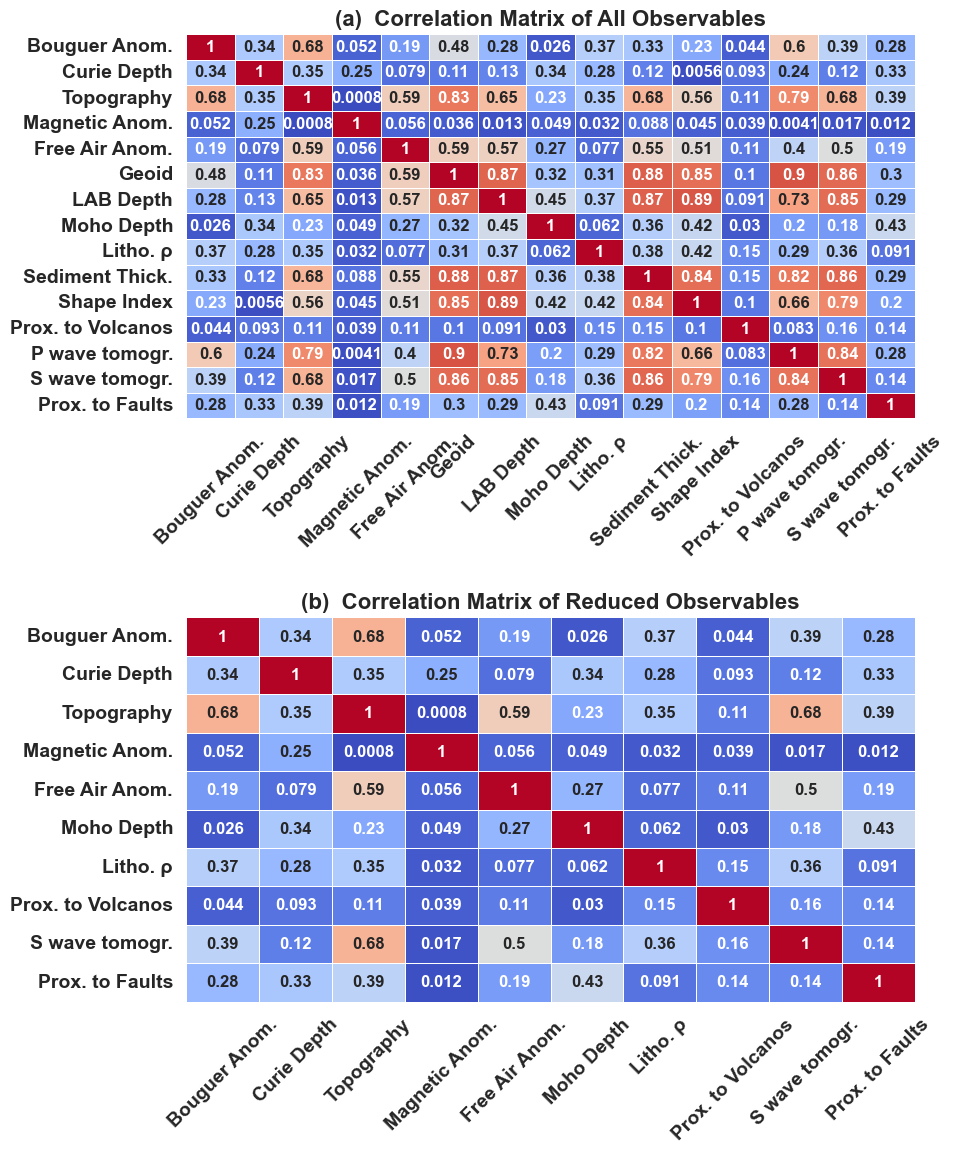

In [7]:
def remove_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # Ensure 'VS' is not dropped if it's present
    if 'VS' in to_drop:
        to_drop.remove('VS')
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, to_drop

# Assuming df is your DataFrame containing the features
ghf_non_cor_df, to_drop = remove_highly_correlated_features(ghf_df[observables_lst], threshold=0.8)

correlation_matrix = ghf_df[observables_lst].corr().abs()
correlation_matrix_keep = ghf_non_cor_df.corr().abs()
correlation_matrix_drop = ghf_df[to_drop].corr().abs()

labels = obs_df['LABELS_REDUCED'].values
labels_keep = obs_df.loc[ghf_non_cor_df.columns, 'LABELS_REDUCED'].values
labels_drop = obs_df.loc[to_drop, 'LABELS_REDUCED'].values




######

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.heatmap(correlation_matrix, ax=axes[0], annot=True, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5, cbar=False)
axes[0].set_title('(a)  Correlation Matrix of All Observables')
axes[0].set_xticklabels(labels, rotation=45)
axes[0].set_yticklabels(labels, rotation=0)

sns.heatmap(correlation_matrix_keep, ax=axes[1], annot=True, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5, cbar=False)
axes[1].set_title('(b)  Correlation Matrix of Reduced Observables')
axes[1].set_xticklabels(labels_keep, rotation=45)
axes[1].set_yticklabels(labels_keep, rotation=0,)

plt.tight_layout(pad=2.0)
plt.savefig(DIR/'Fig'/'Fig_S04.png')
plt.show()



In [8]:
obs_df = obs_df.drop(labels=to_drop)
to_drop

['GEOID_A', 'LAB', 'SEDIMENT', 'SI', 'VP']

In [9]:
# Create full header names with short labels of observables for World and germany
observables_lst   = obs_df.index.tolist()
observables_g_lst = observables_lst + COORDs + [GRID_INDEX_G, TARGET]

# Create header names with short labels of observables
observables_ghf_lst = observables_lst + [TARGET]

# Create full header names with long labels of observables for World and germnay
labels_lst   = obs_df.loc[observables_lst, 'LABELS_REDUCED'].values.tolist()
labels_g_lst = labels_lst + ['lon', 'lat', GRID_INDEX_G, TARGET]

# Create header names with long labels of observables
labels_ghf_lst = labels_lst + [TARGET_LABEL]



#get observables from GHF training
X = ghf_df[observables_lst]
y = ghf_df[TARGET]
weights = ghf_df['normalized_weights']


In [10]:
RANDOM_STATE = 42
n_splits = 4

# CV train test data
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Lists to store indices of each split
train_indices_list = []
test_indices_list = []

# Enumerate over each split
for i, (train_indices, test_indices) in enumerate(kf.split(X)):
    # Store the indices in their respective lists
    train_indices_list.append(train_indices)
    test_indices_list.append(test_indices)

# Step 3: Train a QRT regression model with non clustered data

# Helper functions

In [11]:
def fit_predict_and_evaluate(model, data_df, selected_features, result_df, train_indices, test_indices, qauntiles):
    model.fit(data_df.loc[train_indices, selected_features].values,
              data_df.loc[train_indices, TARGET].values, sample_weight=weights[train_indices])
    result_df = model.calculate_metrics_and_uncertainties(
        data_df.loc[test_indices, selected_features].values, result_df, test_indices, qauntiles)
    return result_df


def create_metrics(y_test, y_test_median, y_test_lower, y_test_upper):
    lbw, ubw = y_test_median - y_test_lower, y_test_upper - y_test_median
    X_for_ucc = form_D_for_auucc(y_test_median, lbw, ubw)
    ucc = UncertaintyCharacteristicsCurve().fit(X_for_ucc, y_test)
    return ucc





In [12]:
def display_results(df, ax, excess, missrate, deficit):
    # Prepare the prediction dictionary
    pred_dict = {
        'y': df['y'],
        'y_median': df['MD'],
        'y_upper': df['UQ'],
        'y_lower': df['LQ']
    }

    # Create DataFrame from the dictionary
    pred_df = pd.DataFrame(data=pred_dict)
    # Ensure the DataFrame is sorted based on the median predictions
    pred_df_sorted = pred_df.sort_values(by='y_median')
    
    pred_df_sorted['midpoint'] = (pred_df_sorted['y_upper'] + pred_df_sorted['y_lower']) /2
    bandwidth = (pred_df_sorted['y'] - pred_df_sorted['midpoint']).abs() 

    # Define points based on excess, missrate, and deficit
    exess_points       =  bandwidth <= (missrate -excess)
    missrate_points    = (bandwidth >  (missrate- excess)) & (bandwidth <= missrate)
    deficit_points     = (bandwidth >  missrate)           & (bandwidth <= (missrate + deficit))
    far_deficit_points =  bandwidth >  (missrate + deficit)
    

    # Calculate the total number of points
    total_points = len(pred_df_sorted)
    exess_points_count = exess_points.sum()
    missrate_points_count = missrate_points.sum()
    deficit_points_count = deficit_points.sum()
    far_deficit_points_count = far_deficit_points.sum()

    # Calculate percentages relative to total points
    exess_points_count_percentage = (exess_points_count / total_points) * 100 if total_points > 0 else 0
    missrate_points_count_percentage = (missrate_points_count / total_points) * 100 if total_points > 0 else 0
    deficit_points_count_percentage = (deficit_points_count / total_points) * 100 if total_points > 0 else 0
    far_deficit_points_count_percentage = (far_deficit_points_count / total_points) * 100 if total_points > 0 else 0

    # Plot the observed data points with different colors based on conditions
    ax.scatter(pred_df_sorted['y_median'][exess_points], 
               pred_df_sorted['y'][exess_points], 
               c='green', label=f'Very High (<= {missrate -excess:.2f}) [{exess_points_count_percentage:.1f}%]', s=20)

    ax.scatter(pred_df_sorted['y_median'][missrate_points], 
               pred_df_sorted['y'][missrate_points], 
               c='red', label=f'High ({missrate - excess:.2f} < x <= {missrate:.2f}) [{missrate_points_count_percentage:.1f}%]', s=20)

    ax.scatter(pred_df_sorted['y_median'][deficit_points], 
               pred_df_sorted['y'][deficit_points], 
               c='blue', label=f'Moderate ({missrate:.2f} < x <= {missrate + deficit :.2f}) [{deficit_points_count_percentage:.1f}%]', s=20)

    ax.scatter(pred_df_sorted['y_median'][far_deficit_points], 
               pred_df_sorted['y'][far_deficit_points], 
               c='cyan', label=f'Low (> {missrate + deficit :.2f}) [{far_deficit_points_count_percentage:.1f}%]', s=20)

    # Plot the upper and lower bounds
    ax.plot(pred_df_sorted['y_median'], pred_df_sorted['y_upper'], 'k--', lw=1, label='25th & 75th Quantiles')
    ax.plot(pred_df_sorted['y_median'], pred_df_sorted['y_lower'], 'k--', lw=1)

    # Add the identity line
    min_val = min(pred_df_sorted['y_median'].min(), pred_df_sorted['y'].min())
    max_val = max(pred_df_sorted['y_median'].max(), pred_df_sorted['y'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    # Ensure the axes are labeled correctly and set the limits
    ax.set_xlabel('Modeled GHF (mW/m$^2$)')
    ax.set_ylabel('Measured GHF (mW/m$^2$)')
    ax.set_xticklabels(np.arange(20, 210, 20))
    ax.set_yticklabels(np.arange(20, 210, 20))

    ax.set_title('(a)  Modeled vs Measured GHF')

    # Add legend and grid
    legend = ax.legend(title='Precision (mW/m$^2$)', loc='lower right', frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    ax.grid(True, linestyle='--', alpha=0.6)


def plot_ucc(uccs, axs):
    """Plot Uncertainty Characteristics Curves for given coordinates."""
    coordinates = [('bandwidth', 'missrate'), ('excess', 'deficit')]
    labels = ['(a)', '(b)']
    xlabels = ['Bandwidth', 'Excess']
    ylabels = ['Missrate', 'Deficit']
    units = ['%', '(mW/m$^2$)']
    
    for coord_idx, (x_axis_name, y_axis_name) in enumerate(coordinates):
        ax = axs[coord_idx]
        auccs_gains = []
        uccs.set_coordinates(x_axis_name=x_axis_name, y_axis_name=y_axis_name, normalize=True)
        auccs_gains.append(uccs.get_AUUCC())
            
        # Sort the AUC values while keeping track of the original indices
        sorted_auccs_with_idx = sorted(enumerate(auccs_gains), key=lambda x: x[1], reverse=True)

        # Extract the sorted indices
        sorted_indices = [idx for idx, auc in sorted_auccs_with_idx]

        # Now, sorted_indices contains the indices of recs_rf sorted by their AUC in descending order
        uccs.set_coordinates(x_axis_name=x_axis_name, y_axis_name=y_axis_name, normalize=False)
        plot_UCC(uccs, title=f'{labels[coord_idx]}  UCC: {xlabels[coord_idx]} vs {ylabels[coord_idx]}',
         ax=ax, syslabel='')
        ax.set_xlabel(f'{xlabels[coord_idx]} {units[1]}')
        ax.set_ylabel(f'{ylabels[coord_idx]} {units[coord_idx]}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)



In [13]:
tuned_hyperparameters

OrderedDict([('max_depth', 12),
             ('max_features', 0.8999999999999999),
             ('max_samples', 0.6),
             ('min_samples_leaf', 3),
             ('min_samples_split', 6),
             ('n_estimators', 1300)])

# Feature importance

In [14]:
logging.info('Fitting') 
# calculate importance


qrf = QuantileRegressionForest(**classes).set_params(**config_bl)
qrf.set_params(**tuned_hyperparameters)

#fit optimized pipeline
qrf.fit(X, y, sample_weight=weights)
#qrt.fit(X, y)

# Get the feature importance using Random Forest's feature_importances_ attribute
observables_importance_df = pd.DataFrame({
    "LABELS"        : labels_lst,
    "REF_CODE_TRANS": observables_lst,
    "RI"            : qrf.model.feature_importances_.round(3),
})

logging.info('Terminated') 

#observables_importance_df.sort_values(by="RI", ascending=False)

2024-08-14 23:44:13,274 - INFO - Fitting
2024-08-14 23:44:17,255 - INFO - Terminated


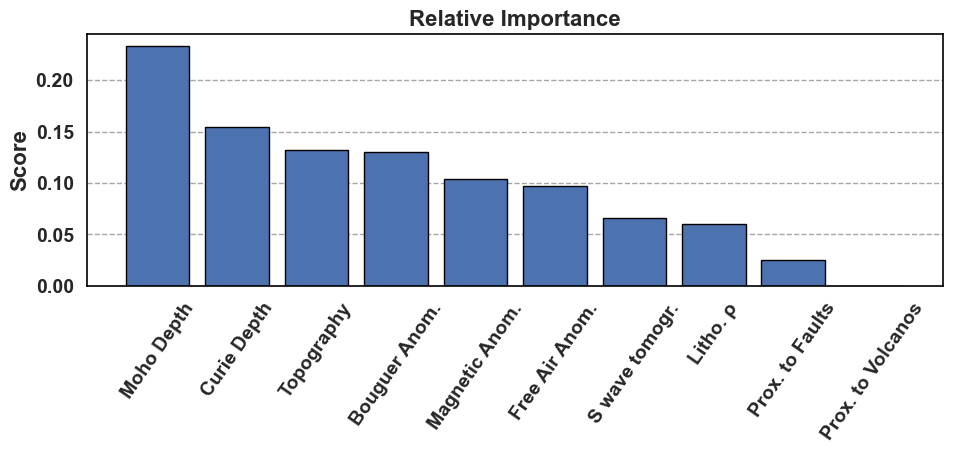

In [15]:
fig, axs = plt.subplots(1, figsize=(10, 5))  # Create a figure
plt.rcParams.update(plt_params)

observables_importance_df.sort_values(by="RI", ascending=False, inplace=True)

# Plot for Random Forest Feature Importance
axs.bar(observables_importance_df['LABELS'], observables_importance_df['RI'], align='center', edgecolor='black')
axs.set_xticklabels(observables_importance_df['LABELS'], rotation=55,)
axs.set_ylabel('Score',)
axs.set_title('Relative Importance')
axs.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout(pad=2.0)

# Save the plot
plt.savefig(DIR/'Fig'/'Fig_S15.png')


# Display the plot
plt.show()


In [16]:


qrf = QuantileRegressionForest(**classes).set_params(**config_bl)
qrf.set_params(**tuned_hyperparameters)


kpis = pd.DataFrame({'y': y})
for train_idx, test_idx in zip(train_indices_list, test_indices_list):
    fit_predict_and_evaluate(qrf , ghf_df, ghf_non_cor_df.columns , kpis, 
                                   train_idx, test_idx, [50, 25, 75])
    

uccs = create_metrics(kpis['y'], kpis['MD'], kpis['LQ'], kpis['UQ'])





Estimating for samples: 100%|██████████████████████████████████████████████████████| 149/149 [00:00<00:00, 3554.78it/s]
2024-08-14 23:44:22,496 - INFO - Calculating Quantiles has been terminated
2024-08-14 23:44:22,501 - INFO - Calculating uncertainties has been terminated - Elapsed time 0.00 s
Estimating for samples: 100%|██████████████████████████████████████████████████████| 149/149 [00:00<00:00, 4456.84it/s]
2024-08-14 23:44:26,585 - INFO - Calculating Quantiles has been terminated - Elapsed time 4.08 s
2024-08-14 23:44:26,585 - INFO - Calculating uncertainties has been terminated - Elapsed time 0.00 s
Estimating for samples: 100%|██████████████████████████████████████████████████████| 149/149 [00:00<00:00, 3319.64it/s]
2024-08-14 23:44:30,851 - INFO - Calculating Quantiles has been terminated - Elapsed time 4.27 s
2024-08-14 23:44:30,856 - INFO - Calculating uncertainties has been terminated - Elapsed time 0.01 s
Estimating for samples: 100%|███████████████████████████████████████

In [17]:
np.quantile(kpis['UT']/np.log(n_classes), 0.25 )

0.7053702416339569

In [18]:
np.quantile(kpis['UT']/np.log(n_classes), 0.75 )

0.7707742267403032

[(7.788298726961336, 0.5798319327731092, 1.0, 1.0)]
[(1.8864017955161319, 6.567148152995499, 1.0, 1.0)]


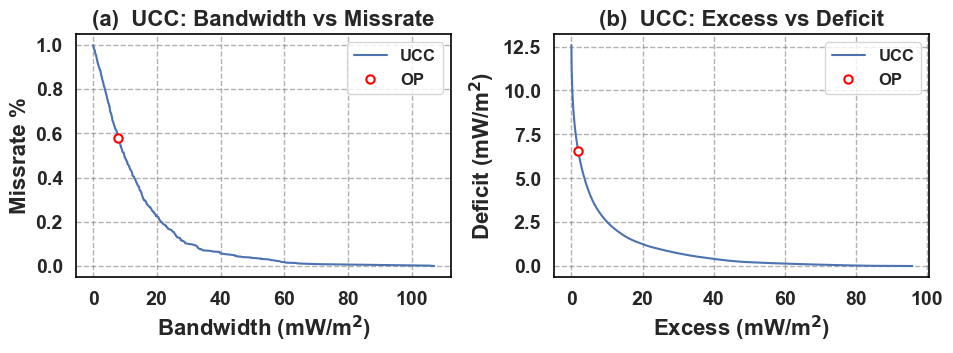

In [19]:

fig, axs = plt.subplots(1,2, figsize=(10, 4))

plot_ucc(uccs, axs)

plt.tight_layout(pad=2.0)
plt.savefig(DIR/'Fig'/'Fig_S11.png')
plt.show()


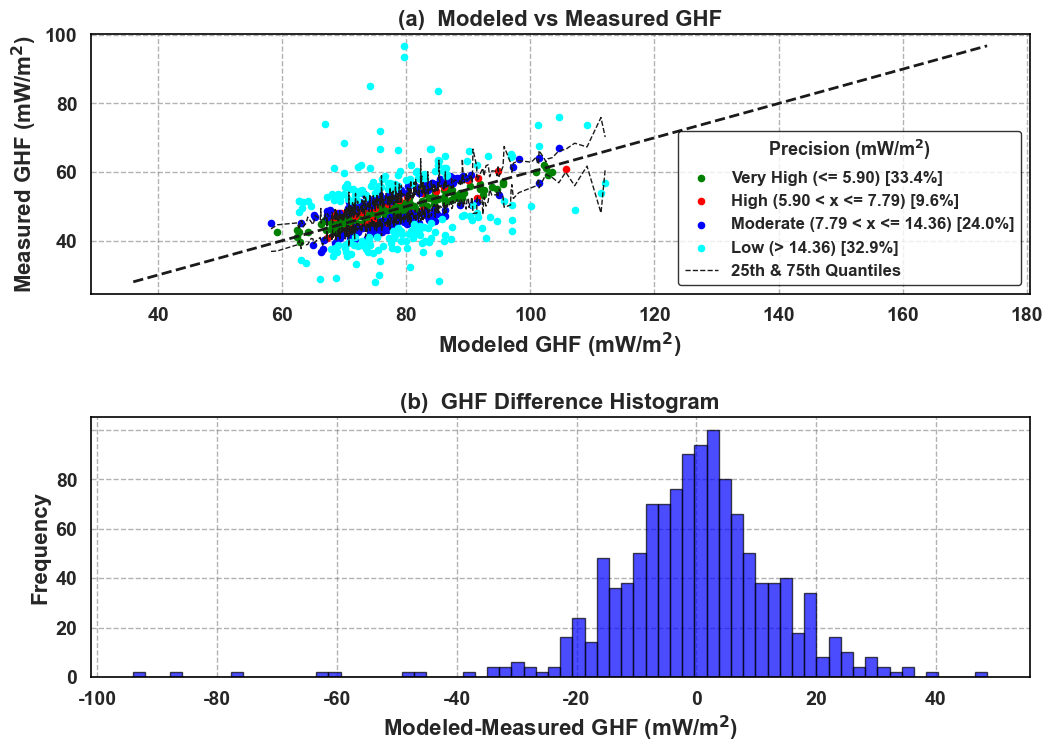

In [20]:

data_diff = kpis['MD'] - kpis['y'] 
    
excess_missrate_deficit = (1.89, 7.79, 6.57)

fig, axs = plt.subplots(2, 1, figsize=(11, 8))

display_results(kpis, axs[0], excess_missrate_deficit[0], excess_missrate_deficit[1], excess_missrate_deficit[2])



axs[1].hist(data_diff, bins=70, color='blue', edgecolor='black', alpha=0.7)

# Add title and labels
axs[1].set_title(f'(b)  GHF Difference Histogram')
axs[1].set_xlabel('Modeled-Measured GHF (mW/m$^2$)')
axs[1].set_ylabel('Frequency')
axs[1].set_xticklabels(np.arange(-120, 90, 20))
axs[1].set_yticklabels(np.arange(0, 90, 20))
# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout(pad=2.0)
plt.savefig(DIR/'Fig'/'Fig_10.png')
plt.show()


# PICP

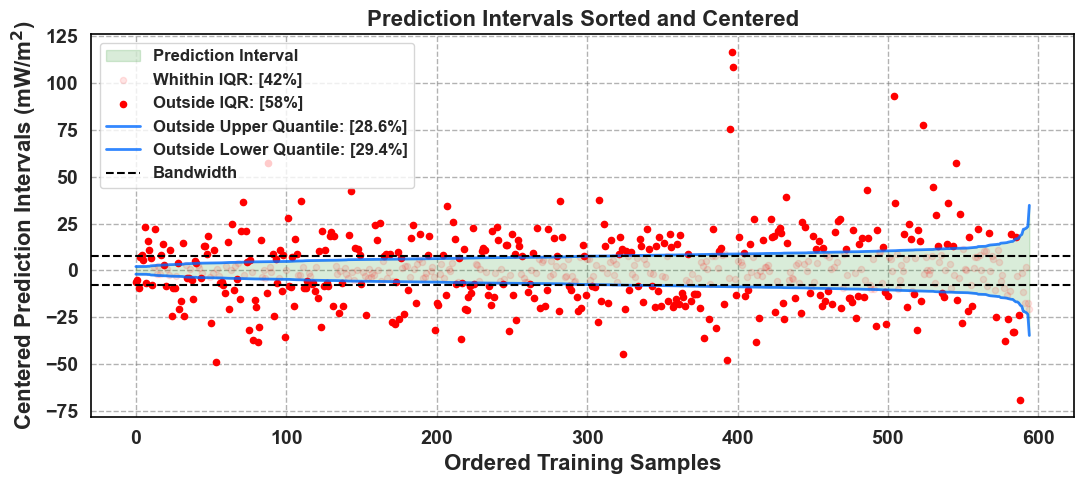

In [21]:

def plot_prediction_intervals(dfs, hls, title):
    df = dfs
    hl = hls

    # Calculate intervals and centered values
    df['interval'] = df['UQ'] - df['LQ']
    df['midpoint'] = (df['UQ'] + df['LQ']) / 2
    df['Inside'] = (df['y'] >= df['LQ']) & (df['y'] <= df['UQ'])
    df['y_true_centered'] = df['y'] - df['midpoint']
    df['upper_bounds_centered'] = df['UQ'] - df['midpoint']
    df['lower_bounds_centered'] = df['LQ'] - df['midpoint']

    # Sort dataframe by interval
    df = df.sort_values(by='interval').reset_index(drop=True)

    # Calculate statistics
    outside_LQ = ((df['y'] < df['LQ']).sum() / df.shape[0]) * 100
    outside_UQ = ((df['y'] > df['UQ']).sum() / df.shape[0]) * 100
    percentage_within_interval = (df['Inside'].sum() / df.shape[0]) * 100

    # Plotting
    plt.figure(figsize=(11, 5))
    plt.fill_between(np.arange(len(df)), df['lower_bounds_centered'], df['upper_bounds_centered'], alpha=0.15, color="green", label="Prediction Interval")
    plt.scatter(np.arange(len(df)), df['y_true_centered'], c='red', marker='o', s=20, label=f"Whithin IQR: [{percentage_within_interval:.0f}%]", alpha=0.1)
    outside_interval_centered = ~df['Inside']
    plt.scatter(np.arange(len(df))[outside_interval_centered], df['y_true_centered'][outside_interval_centered], c='red', marker='o', s=20, label=f"Outside IQR: [{100 - percentage_within_interval:.0f}%]")

    plt.plot(np.arange(len(df)), df['lower_bounds_centered'], alpha=0.8, c="#006aff", lw=2, label=f'Outside Upper Quantile: [{outside_UQ:.1f}%]')
    plt.plot(np.arange(len(df)), df['upper_bounds_centered'], alpha=0.8, c="#006aff", lw=2, label=f'Outside Lower Quantile: [{outside_LQ:.1f}%]')
    plt.axhline(y=hl, color='black', linestyle='--', label=f'Bandwidth')
    plt.axhline(y=-hl, color='black', linestyle='--', )

    # Annotations and labels
    plt.xlabel("Ordered Training Samples")
    plt.ylabel("Centered Prediction Intervals (mW/m$^2$)")
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(DIR/'Fig'/'Fig_S14.png')
    plt.show()

miss_rates = 7.74
plot_prediction_intervals(kpis, miss_rates, f"Prediction Intervals Sorted and Centered")


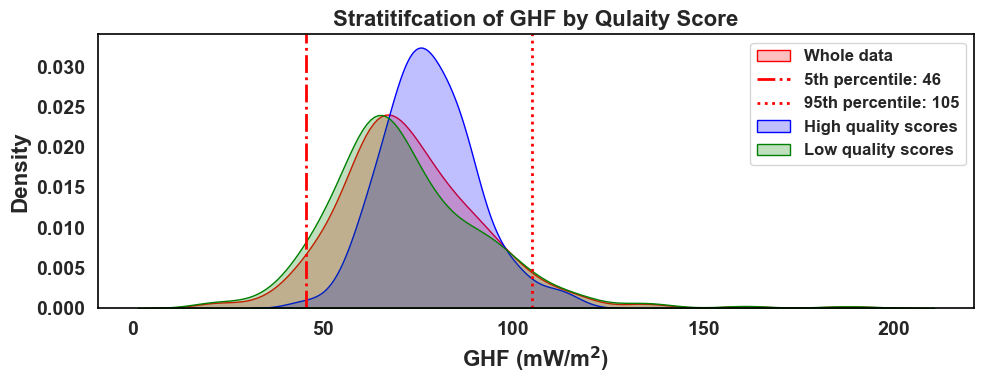

In [22]:
# Assuming ghf_df is your DataFrame and 'score' and 'GHF' are columns in your DataFrame

# Filter the data
ghf_below_4 = ghf_df[ghf_df['score'] <= 4]['GHF']
ghf_above_4 = ghf_df[ghf_df['score'] > 4]['GHF']

data = ghf_df['GHF']
# Calculate statistics
mean_value = np.mean(data)
median_value = np.median(data)
lower_quartile = np.percentile(data, 5)
upper_quartile = np.percentile(data, 95)

# Create the KDE plots on the same figure
rig, ax= plt.subplots(1, figsize=(10, 4))

# KDE plot for GHF values where score is > 4
sns.kdeplot(data, shade=True, color='red', ax=ax, label='Whole data')

#ax.axvline(mean_value, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_value:.2f}')
#ax.axvline(median_value, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
ax.axvline(lower_quartile, color='red', linestyle='-.', linewidth=2, label=f'5th percentile: {lower_quartile:.0f}')
ax.axvline(upper_quartile, color='red', linestyle=':', linewidth=2, label=f'95th percentile: {upper_quartile:.0f}')


# KDE plot for GHF values where score is <= 4
sns.kdeplot(ghf_below_4, shade=True, color='blue', ax=ax, label='High quality scores')

# KDE plot for GHF values where score is > 4
sns.kdeplot(ghf_above_4, shade=True, color='green', ax=ax, label='Low quality scores')

# Add titles and labels
plt.title('Stratitifcation of GHF by Qulaity Score')
plt.xlabel('GHF (mW/m$^2$)')
plt.ylabel('Density')


# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig(DIR/'Fig'/'Fig_S12.png')
plt.show()

Aggregating counts: 100%|█████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 788.16it/s]


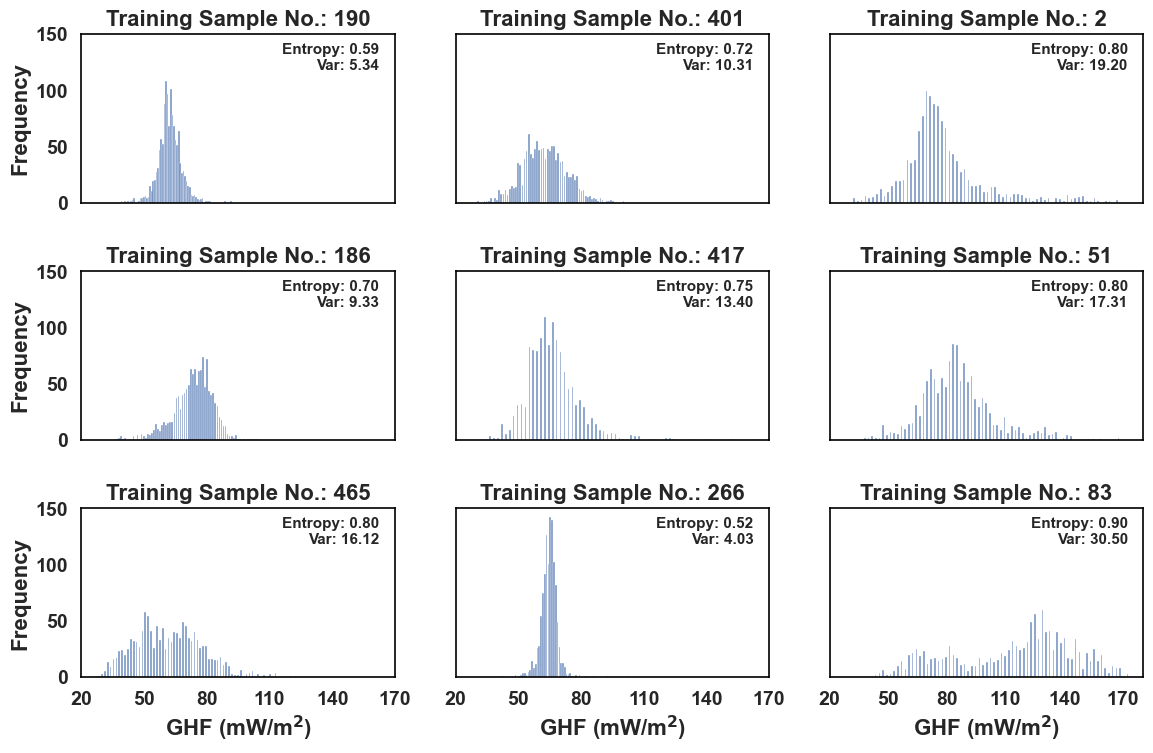

In [23]:
values_vector = qrf.retrieve_values(X)

counts_matrix = qrf.retrieve_counts(X)

def entropy(probabilities):
    """
    Calculate the entropy of a probability distribution.
    """
    probabilities = np.clip(probabilities, 1e-9, 1.0)
    return -np.sum(probabilities * np.log(probabilities), axis=-1)

# Assuming counts_matrix and values_vector are defined
sample_class_counts = np.sum(counts_matrix, axis=1, keepdims=True)
y_prob_samples_normalized = counts_matrix / sample_class_counts

variances = np.nanstd(values_vector, axis=1)
random_idx = [np.random.randint(0, counts_matrix.shape[0]) for _ in range(7)]

# Calculate entropy for each sample
entropy_values = [entropy(prob) for prob in y_prob_samples_normalized]

# Find the indices of the smallest and highest entropy values
random_idx.append(np.argmin(entropy_values))
random_idx.append(np.argmax(entropy_values))

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, sample_idx in enumerate(random_idx):
    ax = axes[idx]
    variance = variances[sample_idx]
    prob_sum = entropy(y_prob_samples_normalized[sample_idx])
    entropy_value = prob_sum / np.log(GHF_BOUNDS[1] - GHF_BOUNDS[0])
    
    
    # Improved bar plot with custom colors
    sns.histplot(values_vector[sample_idx], ax=ax, bins=70)

    # Adjust the width of the bars
    for patch in ax.patches:
        patch.set_width(0.8)  # Adjust this value as needed
    
    # Add annotation
    ax.text(0.95, 0.95, f'Entropy: {entropy_value:.2f}\nVar: {variance:.2f}',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.3', 
                                                   facecolor='white', alpha=0.5))
    
    ax.set_xticks(np.arange(GHF_BOUNDS[0], GHF_BOUNDS[1], 30))
    
    y_ticks = np.arange(0, 151, 50)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick}' for tick in y_ticks])
    
    ax.set_title(f'Training Sample No.: {sample_idx}')
    
    # Remove x-ticks for plots 0-5
    if idx < 6:  # Zero-based indexing
        ax.set_xticklabels([])
        
    if idx >= 6:  # Zero-based indexing        
        ax.set_xlabel('GHF (mW/m$^2$)')
    
    # Remove y-ticks for plots 1, 2, 4, 5, 7, 8       
    if idx % 3 == 0:  # Zero-based indexing
        ax.set_ylabel('Frequency')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

# Turn off the unused subplot
for ax in axes[len(random_idx):]:
    ax.axis('off')

# Adjust layout
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout(pad=2.0)
plt.savefig(DIR/'Fig'/'Fig_S06.png')
plt.show()